In [1]:
from tqdm import tqdm
from pathlib import Path
import glob
import os
import tables as tb
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.stats import entropy
import numpy as np
import pickle

## As the model has not been thoroughly tested and there are many wild state estimates in the original data, it is recommended to perform inference only on the cells below.

In [2]:
cells = ['batch_B12A_cell_4',
'batch_B14A_cell_10',
'batch_B14B_cell_5',
'batch_B7B_cell_4',
'batch_B9A_cell_5',
'batch_B7B_cell_1',
'batch_B14A_cell_11',
'batch_B7B_cell_2',
'batch_B9B_cell_4',
'batch_B4A_cell_2',
'batch_B4A_cell_5',
'batch_B14B_cell_9']

In [3]:
all_qts = {}
for path in tqdm(Path('asoh-estimates').glob('*h5')):
    if os.path.basename(path).replace('.asoh.h5','') in cells:
        with tb.open_file(path) as file:
            table = file.get_node('/state_estimates/per_timestep')
            root = file.get_node('/state_estimates/')
            est_volt = table[:]['output_mean'][:, 0]
            state_names = root._v_attrs['state_names']
            est_asoh = pd.DataFrame(table[:]['state_mean'], columns=state_names)
            est_asoh['time'] = table[:]['time']
            all_qts[path.name[:-8]] = est_asoh
        

298it [00:02, 141.51it/s]


### We are ignoring the first 10,000 timestamps as the estimates are unstable and using timestamps 10,001 to 20,000 (a context window of 10,000 timestamps) to make a forecast.

In [4]:
df = all_qts[cells[4]][10000:]
print(df)
df = df.reset_index(drop=True)

             soc      hyst  q_t.base_values          time
10000   0.111480 -0.176358         0.404703  1.075203e+06
10001   0.128964 -0.177657         0.404702  1.075327e+06
10002   0.145414 -0.173387         0.404677  1.075454e+06
10003   0.161683 -0.166535         0.404590  1.075579e+06
10004   0.177715 -0.158123         0.404427  1.075698e+06
...          ...       ...              ...           ...
223154 -0.019036  0.742664         0.374939  2.003811e+07
223155 -0.018783  0.742672         0.374939  2.003841e+07
223156 -0.018607  0.742678         0.374939  2.003871e+07
223157 -0.018468  0.742682         0.374939  2.003901e+07
223158 -0.018464  0.742682         0.374939  2.003902e+07

[213159 rows x 4 columns]


In [5]:
def extract_features(series):
    diff = np.diff(series)
    psd = welch(series, nperseg=50)[1] 
    
    return np.array([
        series.mean(), series.std(), series.min(), series.max(), series.median(),
        skew(series), kurtosis(series), diff.mean(), diff.std(),
        np.percentile(series, 25), np.percentile(series, 75),  
        entropy(np.histogram(series, bins=10)[0] + 1),  
        psd.mean(), psd.std() 
    ])


def poly(x, params):
    return sum([params[i] * x ** i for i in range(len(params))])


    
    

In [6]:

def forecast(df,forecast_model_path= 'camp_forecast_model.pkl',pca_model_path='pca_model.pkl'):
    
    with open(pca_model_path, "rb") as f:
        pca = pickle.load(f)

    with open(forecast_model_path, "rb") as f:
        forecast_model = pickle.load(f)

    series = df['q_t.base_values'][0:10000]
    X = extract_features(series).reshape(1,-1)
    X_pca = pca.transform(series.to_numpy().reshape(1,-1))
    X_combined = np.hstack([X, X_pca])

    model_parameters = forecast_model.predict(X_combined)[0]
    model_parameters = model_parameters[1:round(model_parameters[0]) + 2] 
    
    forecast_len = len(df)
    x = np.linspace(0, forecast_len, forecast_len)
    forecast_vals = np.abs(poly(x, model_parameters))
    forecast_vals = pd.Series(forecast_vals)

    df['forecast'] = np.nan
    df.loc[10000:,'forecast'] =forecast_vals[10000:]
    
    return df
    

In [7]:
df1 = forecast(df)

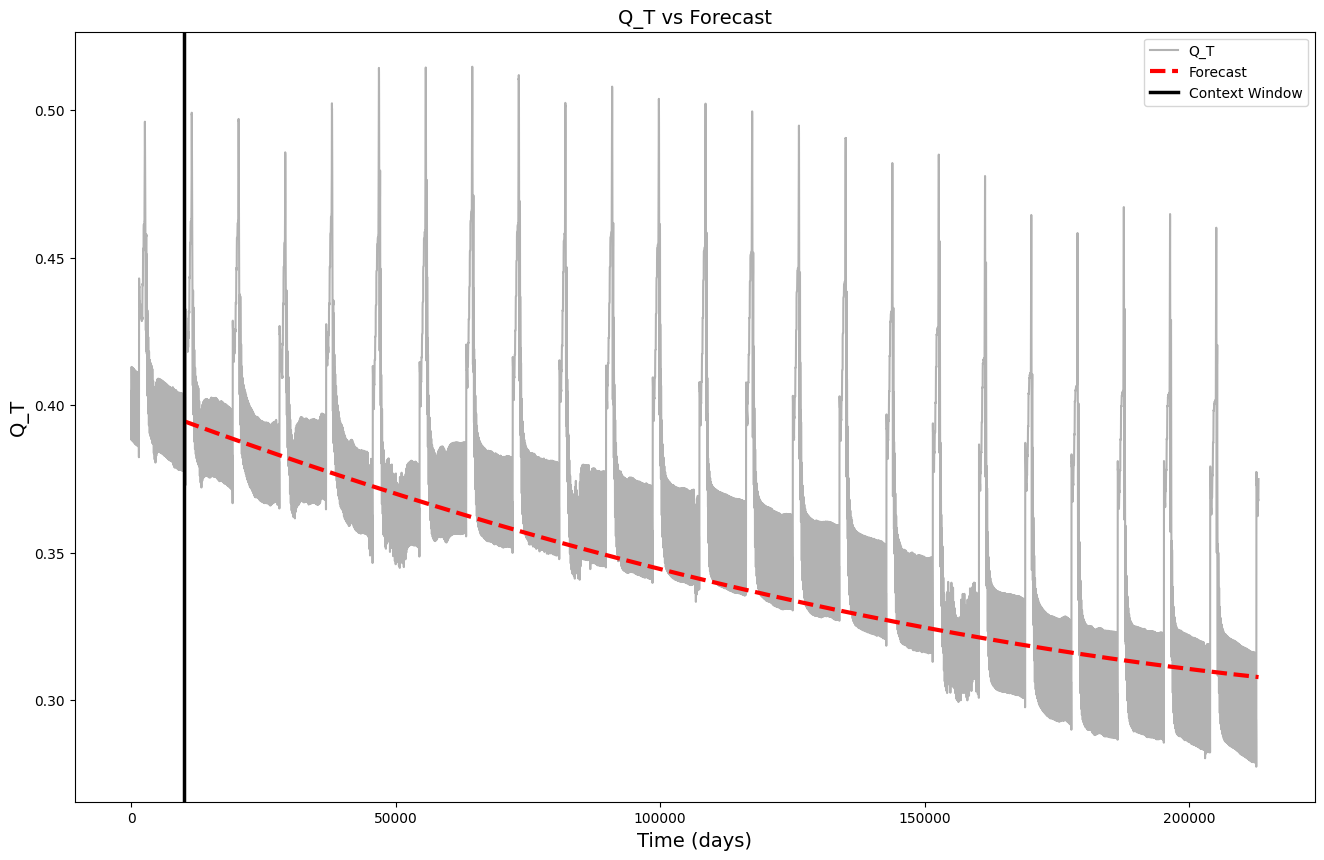

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
plt.plot(df1.index, df['q_t.base_values'], color='gray', alpha=0.6, linewidth=1.5, label='Q_T')
plt.plot(df1.index, df1['forecast'], 'r--', label='Forecast', linewidth=3)

plt.axvline(x=10000, color='black', linewidth=2.5, linestyle='-', label='Context Window')

plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Q_T', fontsize=14)
plt.title('Q_T vs Forecast', fontsize=14)

plt.gca().set_facecolor('white')
plt.grid(False)

plt.legend()
plt.show()
